## Imports


In [1]:
import os
import sys
%load_ext autoreload
%autoreload 2

display("Current working directory: {0}".format(os.getcwd()))

sys.path.append("../../../../")
display("append directory: {0}".format(os.path.abspath("../../../../")))


'Current working directory: /nethome/home3/yuxiang.wu/ML-Snippets/path_explain/examples/natural_language/transformers/sst2'

'append directory: /nethome/home3/yuxiang.wu/ML-Snippets/path_explain'

In [2]:
from path_explain import utils
utils.set_up_environment(visible_devices='3')

2023-09-20 16:37:01.961260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 16:37:04.442766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-20 16:37:04.443278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/
2023-09-20 16:37:04.443287

In [3]:
import tensorflow as tf
import tensorflow_datasets
import numpy as np
import matplotlib.pyplot as plt
import scipy
from transformers import *
from path_explain.plot.text import text_plot, matrix_interaction_plot, bar_interaction_plot

/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/python3.9/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/python3.9/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


## Data and Model Loading


In [4]:
task = 'sst-2'
num_labels = len(glue_processors[task]().get_labels())

/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/python3.9/site-packages/transformers/data/processors/glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [5]:
config = DistilBertConfig.from_pretrained('.', num_labels=num_labels)
# config = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = TFDistilBertForSequenceClassification.from_pretrained(
#     '.', config=config)
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', config=config)


OSError: . does not appear to have a file named config.json. Checkout 'https://huggingface.co/./main' for available files.

In [ ]:
data, info = tensorflow_datasets.load('glue/sst2', with_info=True)

In [ ]:
train_dataset = glue_convert_examples_to_features(
    data['train'], tokenizer, max_length=128, task=task)
valid_dataset = glue_convert_examples_to_features(
    data['validation'], tokenizer, max_length=128, task=task)
valid_dataset = valid_dataset.batch(32)


/nethome/yuxiang.wu/anaconda3/envs/tf-env/lib/python3.9/site-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
Using label list ['0', '1'] for task sst-2
Using output mode classification for task sst-2
*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 2005, 1996, 4895, 5498, 10711, 3064, 3248, 2488, 2006, 2678, 2007, 1996, 2614, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Model Evaluation


In [ ]:
valid_pred = model.predict(valid_dataset)

28/28 [==============================] - 25s 843ms/step


In [ ]:
valid_input = []
valid_labels = []
for batch in valid_dataset:
    valid_input.append(batch[0])
    valid_labels.append(batch[1].numpy())
valid_labels_np = np.concatenate(valid_labels, axis=0)

In [ ]:
# valid_pred_max[positive_mask]
valid_pred_max = np.argmax(valid_pred, axis=-1)
print(valid_pred_max.shape)

()


In [ ]:
valid_pred_max = np.argmax(valid_pred, axis=-1)
accuracy = np.sum(valid_pred_max == valid_labels_np) / len(valid_labels_np)

positive_mask = valid_labels_np == 1

positive_accuracy = np.sum(
    valid_pred_max[positive_mask] == valid_labels_np[positive_mask]) / np.sum(positive_mask)

negative_mask = valid_labels_np == 0
negative_accuracy = np.sum(
    valid_pred_max[negative_mask] == valid_labels_np[negative_mask]) / np.sum(negative_mask)

print('Validation Accuracy: {:.4f}'.format(accuracy))
print('Positive Sentiment Accuracy: {:.4f}'.format(positive_accuracy))
print('Negative Sentiment Accuracy: {:.4f}'.format(negative_accuracy))


IndexError: invalid index to scalar variable.

In [ ]:
batch_conf = valid_pred[:32]
batch_conf = scipy.special.softmax(batch_conf, axis=-1)
batch_pred = np.argmax(batch_conf, axis=-1)
batch_labels = valid_labels[0]
batch_input = valid_input[0]
batch_ids = batch_input['input_ids']
batch_baseline = np.zeros((1, 128), dtype=np.int64)

In [ ]:
def embedding_model(batch_ids):
    batch_embedding = model.distilbert.embeddings(batch_ids)
    return batch_embedding


def prediction_model(batch_embedding):
    attention_mask = tf.ones(batch_embedding.shape[:2])
    attention_mask = tf.cast(attention_mask, dtype=tf.float32)
    head_mask = [None] * model.distilbert.num_hidden_layers

    transformer_output = model.distilbert.transformer(
        [batch_embedding, attention_mask, head_mask], training=False)[0]
    pooled_output = transformer_output[:, 0]
    pooled_output = model.pre_classifier(pooled_output)
    logits = model.classifier(pooled_output)
    return logits


In [ ]:
batch_embedding = embedding_model(batch_ids)

In [ ]:
baseline_embedding = embedding_model(batch_baseline)

In [ ]:
batch_predictions = prediction_model(batch_embedding)

TypeError: call() missing 5 required positional arguments: 'attn_mask', 'head_mask', 'output_attentions', 'output_hidden_states', and 'return_dict'

## Model Interpretation


In [ ]:
def print_sentence(index):
    confidence = batch_conf[index]
    predicted_label = batch_pred[index]
    true_label = batch_labels[index]

    encoded_sentence = batch_ids[index].numpy()
    encoded_sentence = encoded_sentence[encoded_sentence != 0]

    print(tokenizer.decode(encoded_sentence))
    print('This sentence is:\t{}'.format(
        'positive' if true_label == 1 else 'negative'))
    print('DistilBERT predicts:\t{} (confidence {:.4f})'.format('positive' if predicted_label == 1 else 'negative',
                                                                batch_conf[index, predicted_label]))
    print('-------------------------')


In [ ]:
for i in range(batch_ids.shape[0]):
    print_sentence(i)

[CLS] it confirms fincher's status as a film maker who artfully bends technical know - how to the service of psychological insight. [SEP]
This sentence is:	positive
DistilBERT predicts:	positive (confidence 0.9996)
-------------------------
[CLS] too much of it feels unfocused and underdeveloped. [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9986)
-------------------------
[CLS] a great ensemble cast can't lift this heartfelt enterprise out of the familiar. [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9699)
-------------------------
[CLS] prurient playthings aside, there's little to love about this english trifle. [SEP]
This sentence is:	negative
DistilBERT predicts:	negative (confidence 0.9975)
-------------------------
[CLS] it moves quickly, adroitly, and without fuss ; it doesn't give you time to reflect on the inanity - - and the cold war datedness - - of its premise. [SEP]
This sentence is:	positive
DistilBERT predict

In [ ]:
attributions = np.load('attributions.npy')
interactions = np.load('interactions.npy')

In [ ]:
orig_token_list = []
for i in range(batch_ids.shape[0]):
    ids = batch_ids[i].numpy()
    tokens = tokenizer.convert_ids_to_tokens(ids)
    orig_token_list.append(tokens)

In [ ]:
token_list, attribution_list, interaction_list = utils.strip_tokens(
    orig_token_list, attributions, interactions)


In [ ]:
def plot_interactions(tokens,
                      interactions,
                      vmin=None,
                      vmax=None,
                      **kwargs):
    for i in range(len(tokens)):
        select_interactions = interactions[i]
        select_interactions[i] = 0.0
        text_plot(tokens,
                  select_interactions,
                  include_legend=False,
                  vmin=vmin,
                  vmax=vmax,
                  fontsize=16)

In [ ]:
def plot_all(i):
    tokens = token_list[i]
    attribution = attribution_list[i]
    interaction = interaction_list[i]

    text_plot(tokens, attribution, include_legend=True, fontsize=16)

    indices = np.where(~np.eye(interaction.shape[0], dtype=bool))
    bounds = np.max(np.abs(interaction[indices]))
    plot_interactions(tokens, interaction, vmin=-
                      bounds, vmax=bounds, fontsize=16)


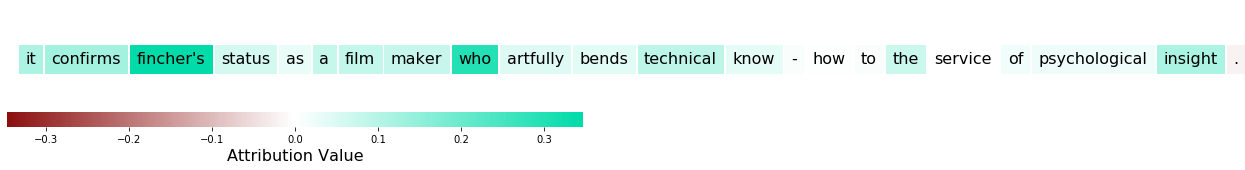

In [ ]:
index = 0
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('fincher_text.pdf')


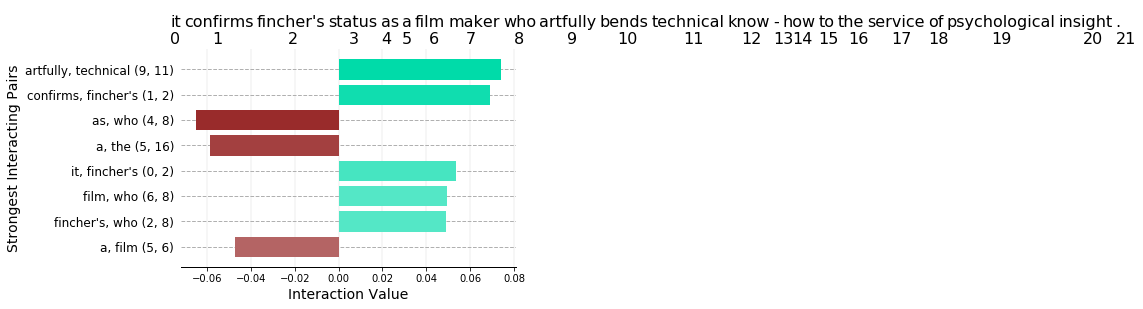

In [ ]:
index = 0
ax, text_ax = bar_interaction_plot(
    interaction_list[index], token_list[index], top_k=8)
plt.savefig('fincher_bar.pdf')


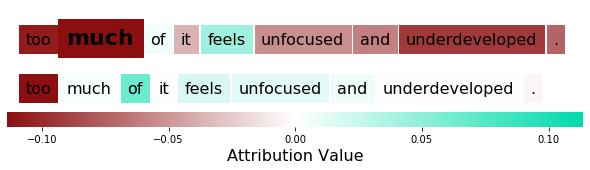

In [ ]:
index = 1
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=1, zero_diagonals=False, include_legend=True)
plt.savefig('too_much_text.pdf')


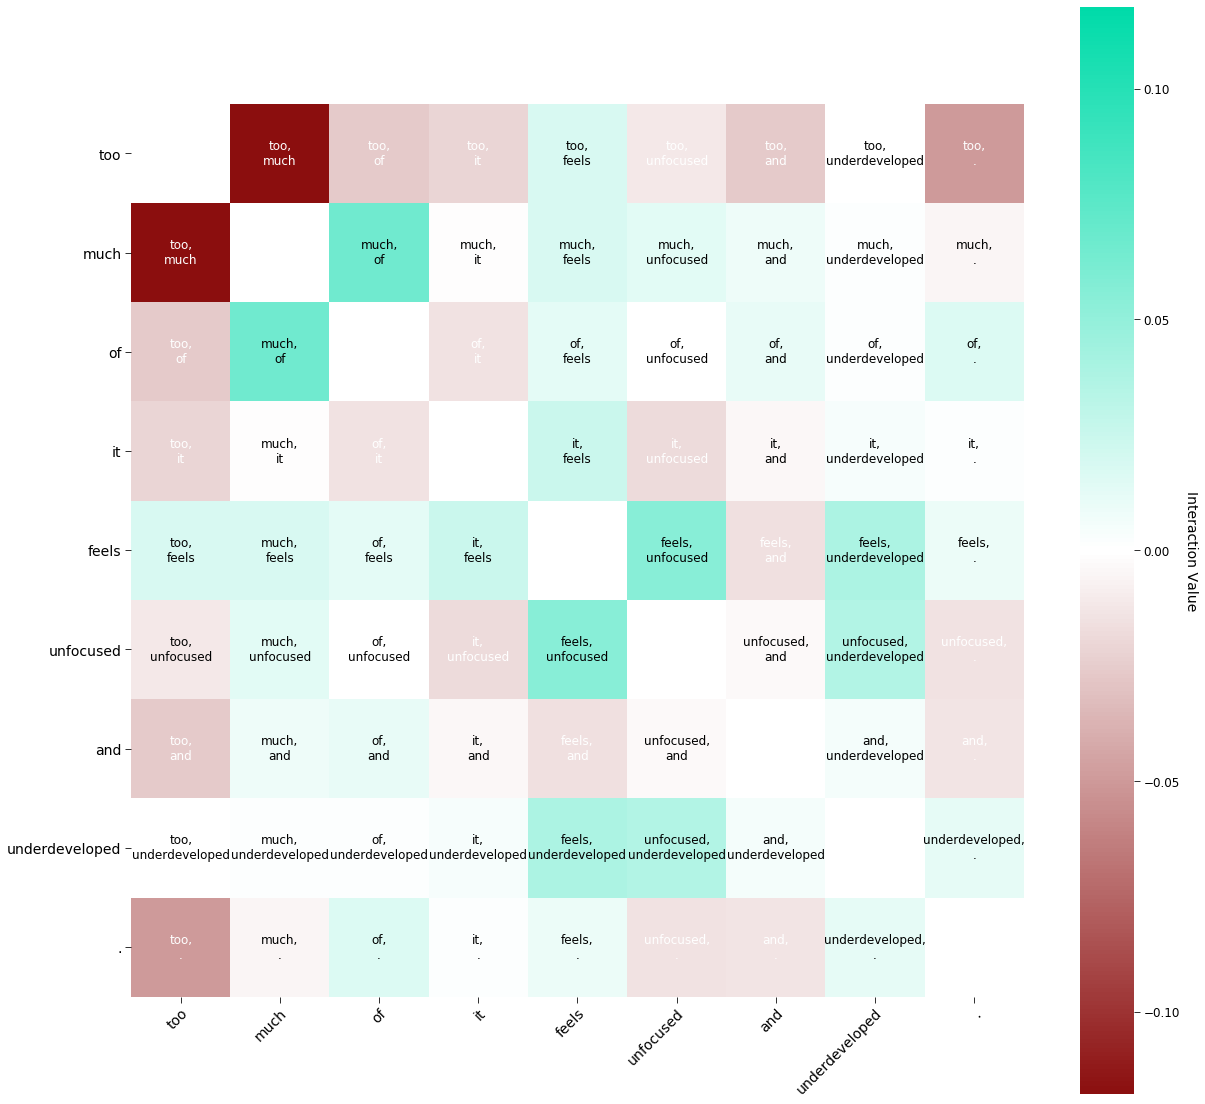

In [ ]:
index = 1
fig, ax = plt.subplots(figsize=(20, 20))
ax, cbar_ax = matrix_interaction_plot(
    interaction_list[index], token_list[index], ax=ax)
plt.savefig('too_much_matrix.pdf')


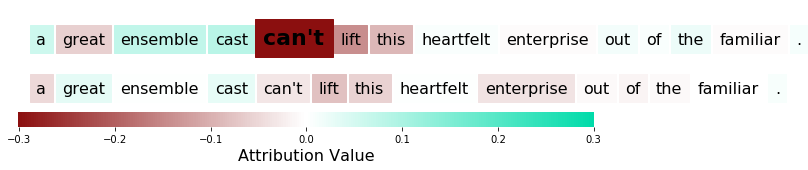

In [ ]:
index = 2
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=4, zero_diagonals=False, include_legend=True)


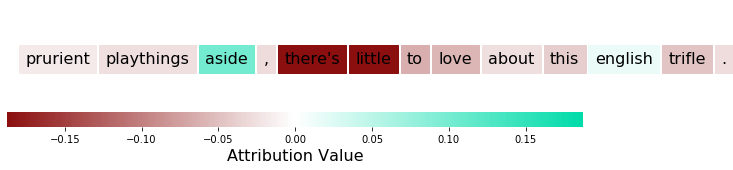

In [ ]:
index = 3
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('little_to_love_text.pdf')


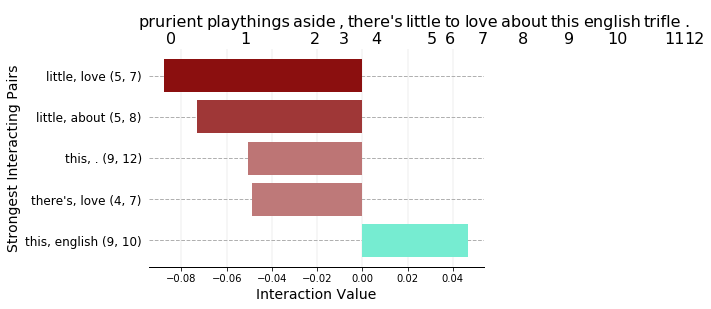

In [ ]:
index = 3
ax, text_ax = bar_interaction_plot(
    interaction_list[index], token_list[index], top_k=5)
plt.savefig('little_to_love_bar.pdf')


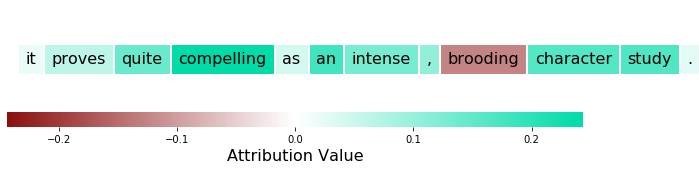

In [ ]:
index = 5
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('quite_compelling_text.pdf')


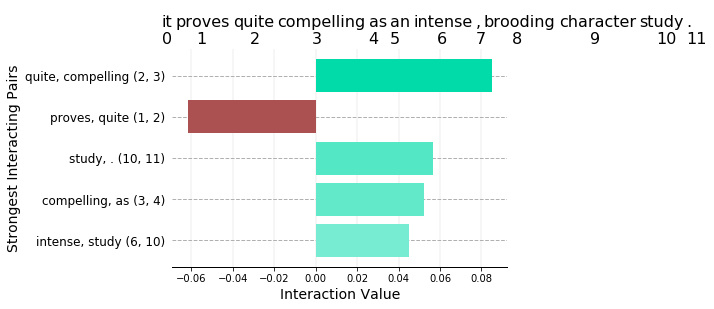

In [ ]:
index = 5
ax, text_ax = bar_interaction_plot(
    interaction_list[index], token_list[index], top_k=5)
plt.savefig('quite_compelling_bar.pdf')


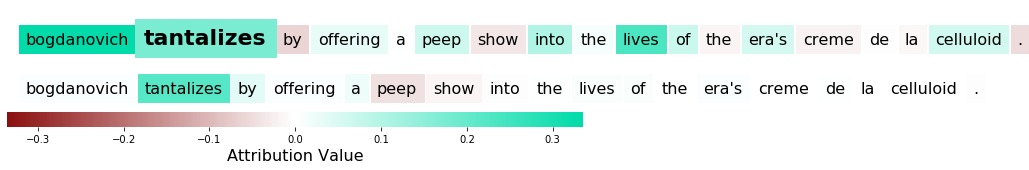

In [ ]:
index = 6
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=1, zero_diagonals=False, include_legend=True)


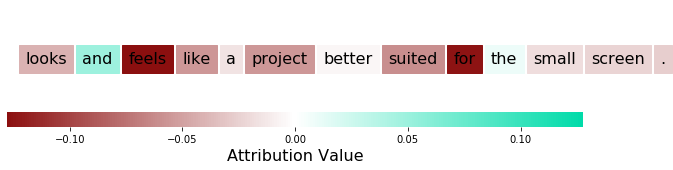

In [ ]:
index = 7
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('better_suited_text.pdf')


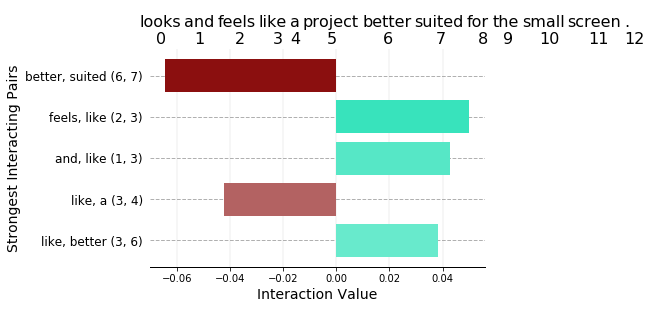

In [ ]:
index = 7
ax, text_ax = bar_interaction_plot(
    interaction_list[index], token_list[index], top_k=5)
plt.savefig('better_suited_bar.pdf')


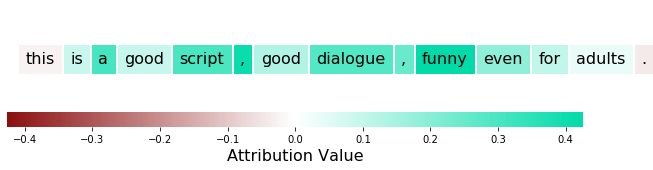

In [ ]:
index = 9
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('good_script_text.pdf')


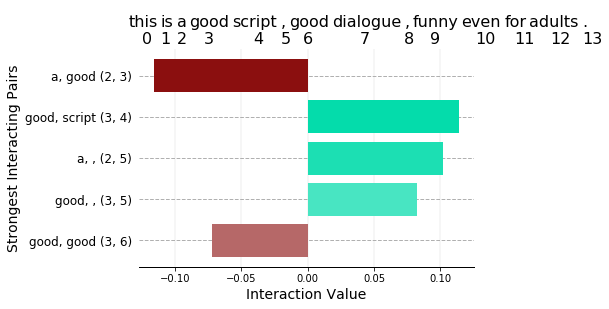

In [ ]:
index = 9
ax, text_ax = bar_interaction_plot(
    interaction_list[index], token_list[index], top_k=5)
plt.savefig('good_script_bar.pdf')


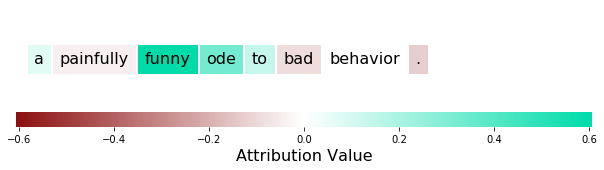

In [ ]:
index = 10
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('painfully_funny_text.pdf')


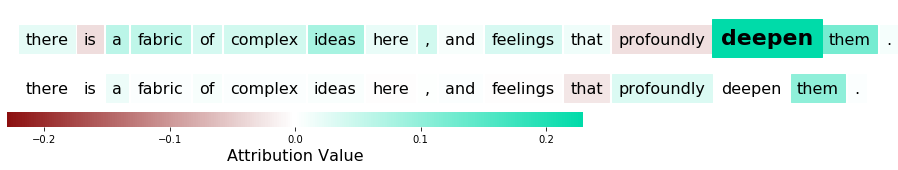

In [ ]:
index = 11
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=13, zero_diagonals=False, include_legend=True)


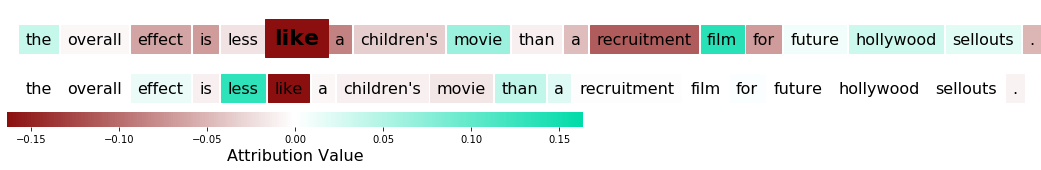

In [ ]:
index = 12
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=5, zero_diagonals=False, include_legend=True)


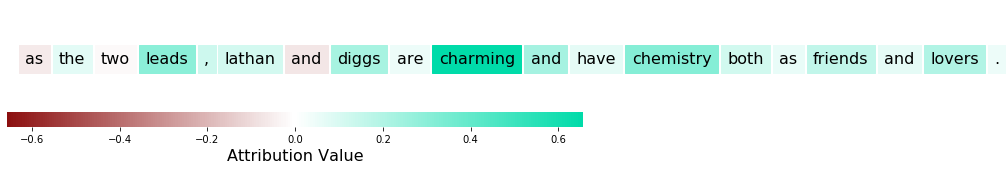

In [ ]:
index = 13
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)


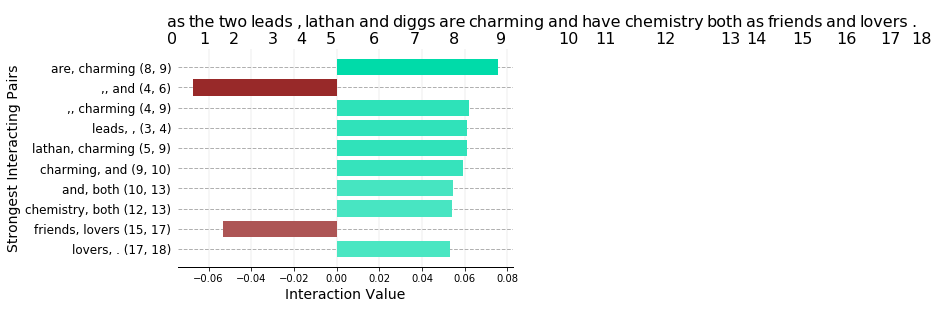

In [ ]:
index = 13
ax, text_ax = bar_interaction_plot(
    interaction_list[index], token_list[index], top_k=10)


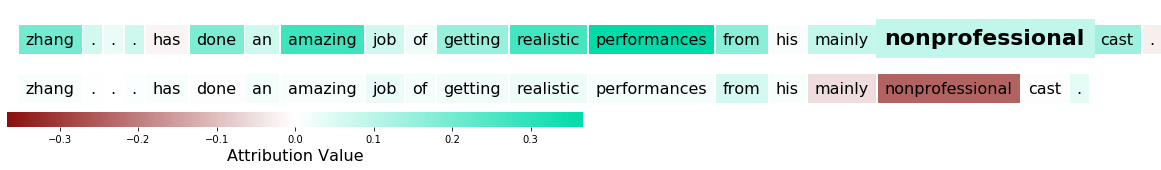

In [ ]:
index = 15
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=16, zero_diagonals=False, include_legend=True)
plt.savefig('mainly_nonprofessional_text.pdf')


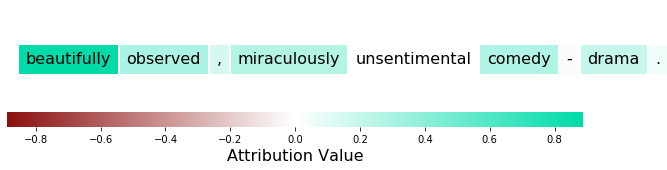

In [ ]:
index = 17
text_plot(token_list[index], attribution_list[index], interaction_matrix=interaction_list[index],
          interaction_index=None, zero_diagonals=False, include_legend=True)
plt.savefig('beautifully_observed_text.pdf')


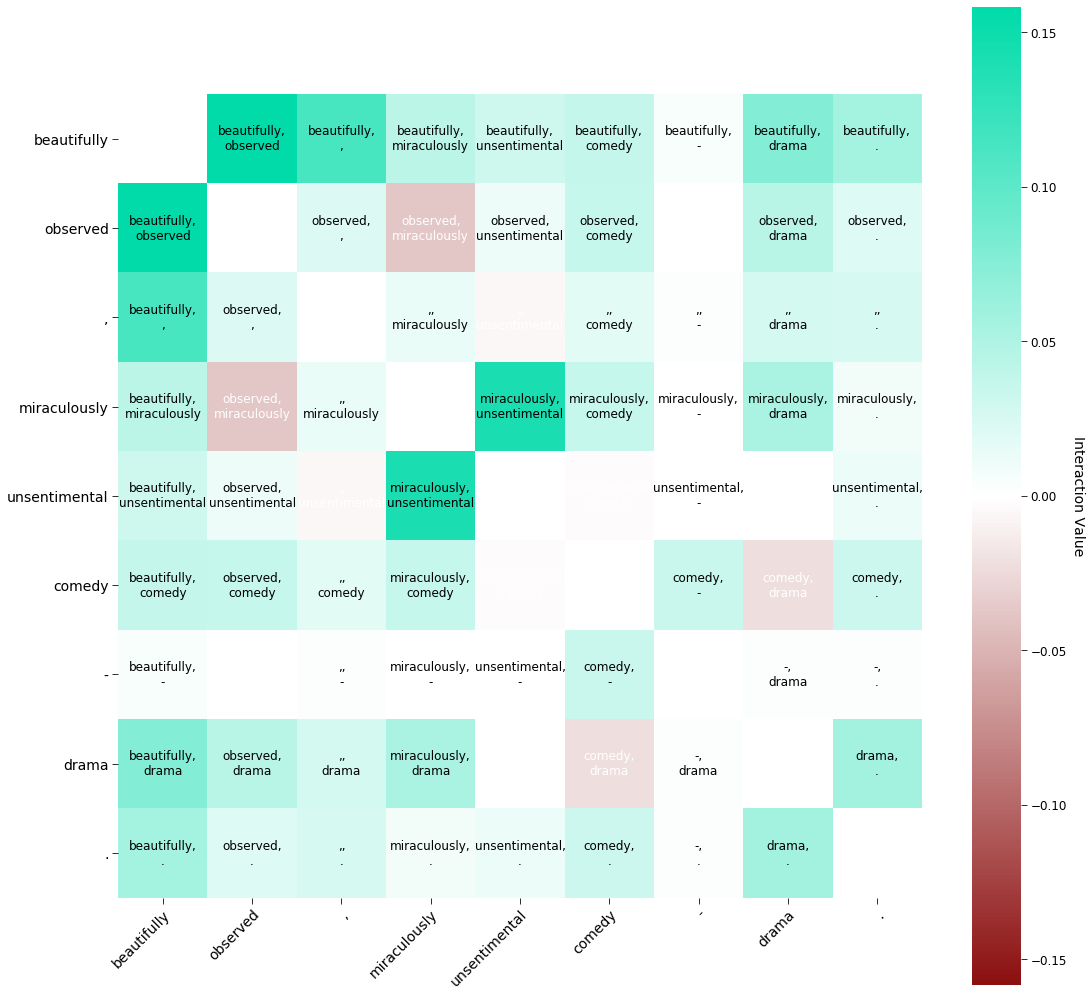

In [ ]:
index = 17
fig, ax = plt.subplots(figsize=(18, 18))
ax, cbar_ax = matrix_interaction_plot(
    interaction_list[index], token_list[index], ax=ax)
plt.savefig('beautifully_observed_matrix.pdf')


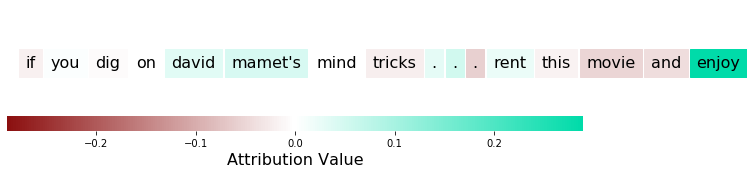

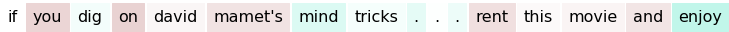

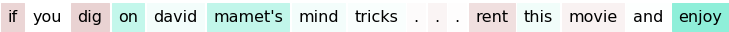

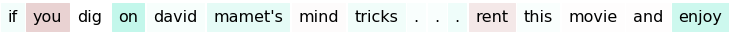

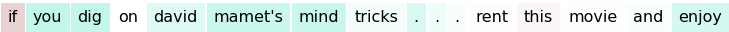

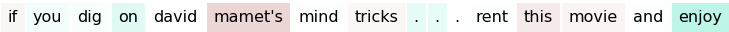

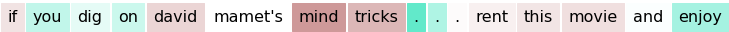

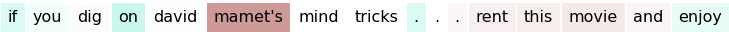

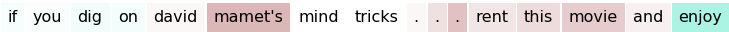

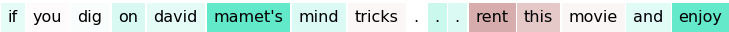

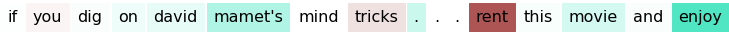

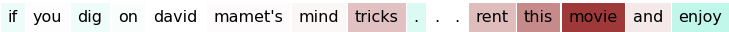

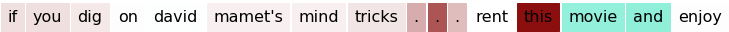

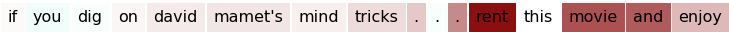

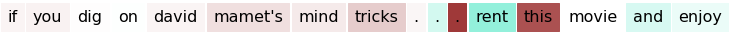

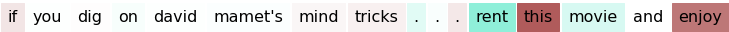

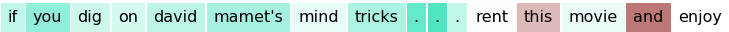

In [ ]:
plot_all(19)

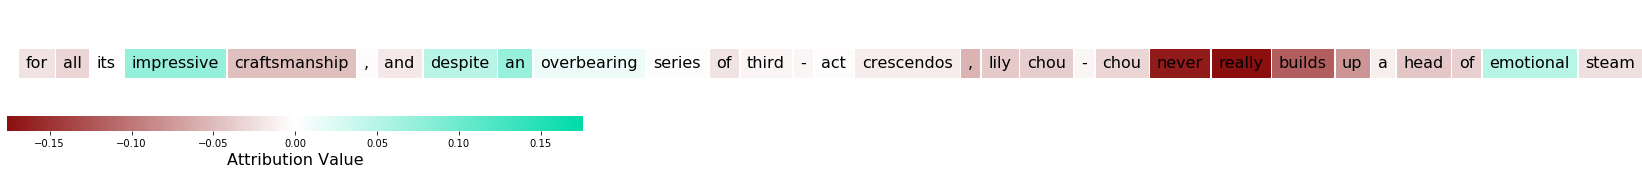

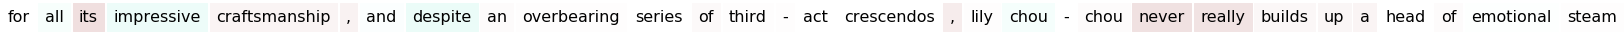

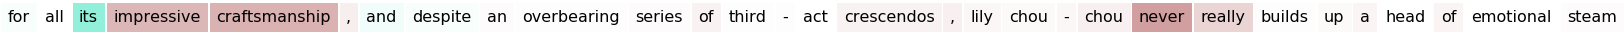

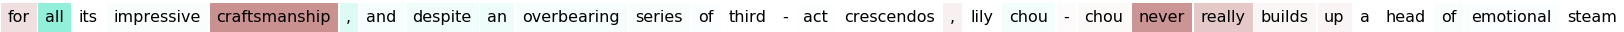

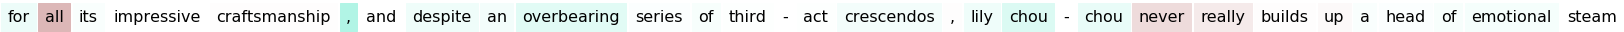

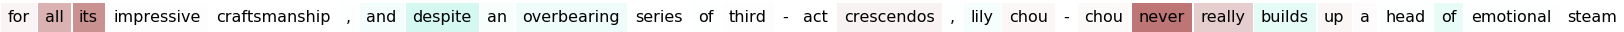

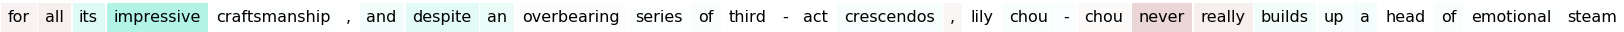

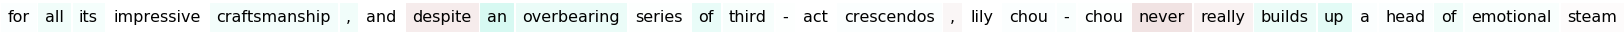

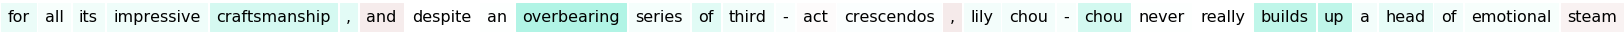

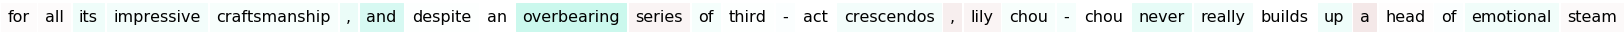

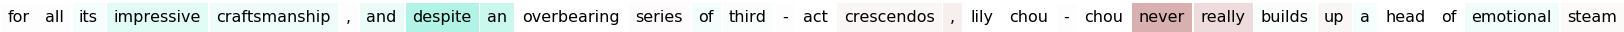

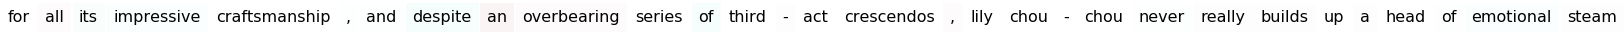

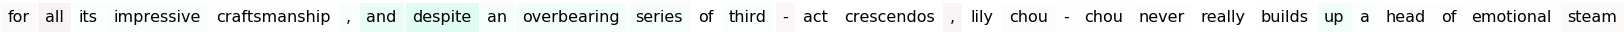

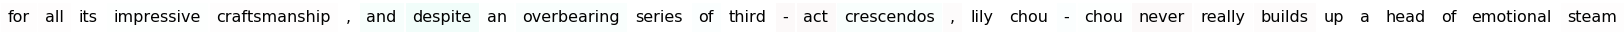

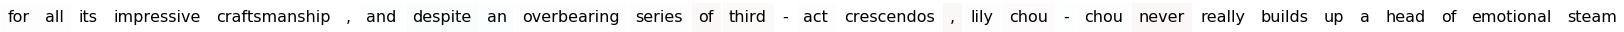

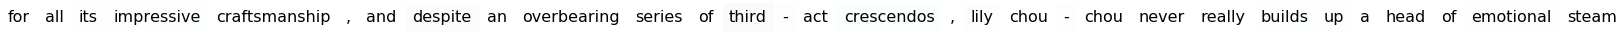

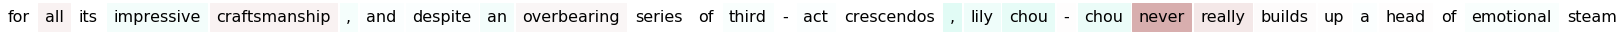

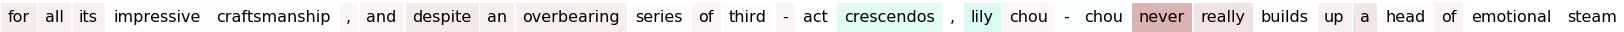

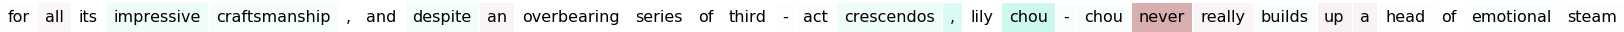

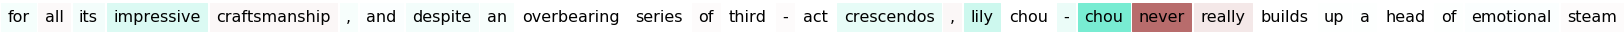

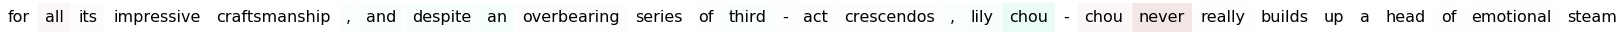

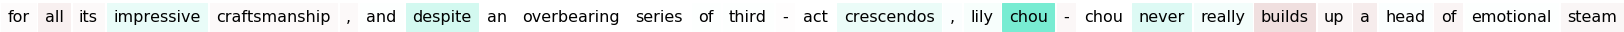

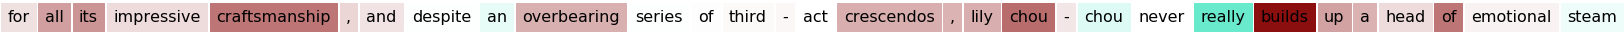

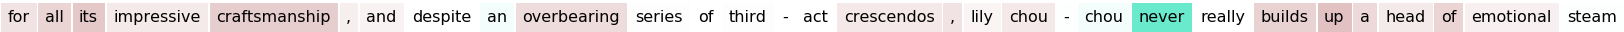

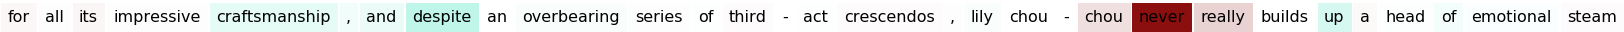

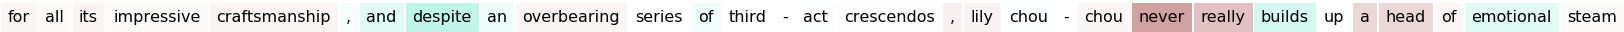

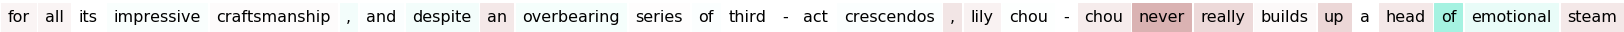

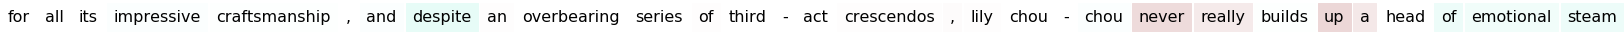

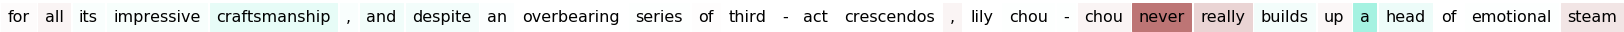

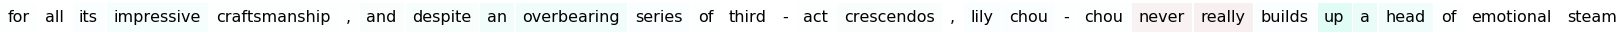

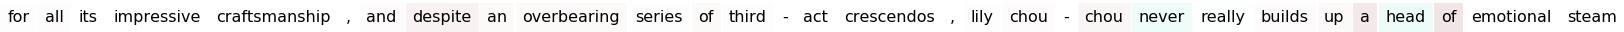

In [ ]:
plot_all(20)

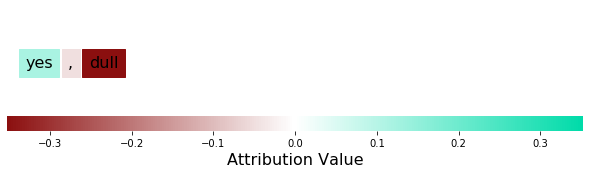

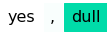

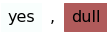

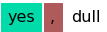

In [ ]:
plot_all(21)

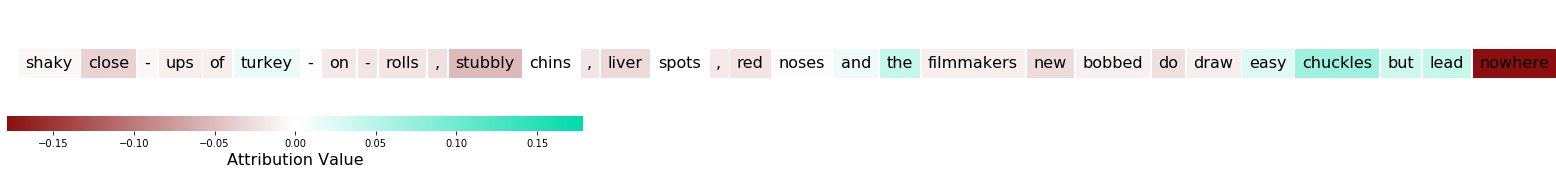

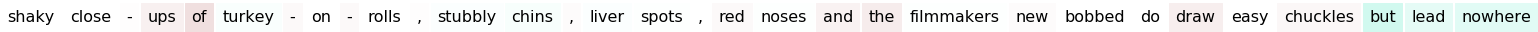

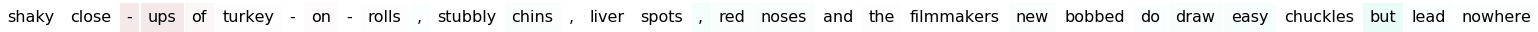

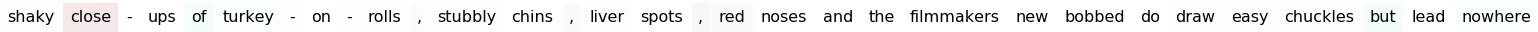

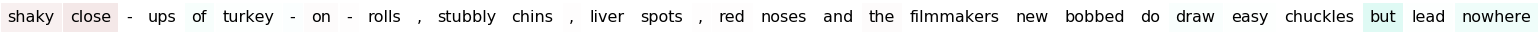

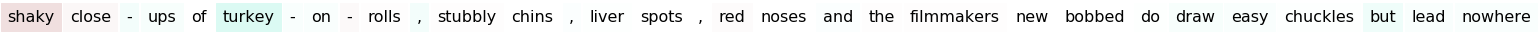

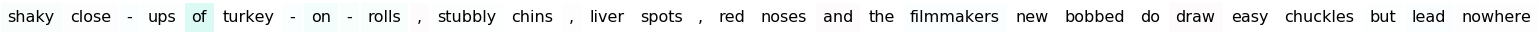

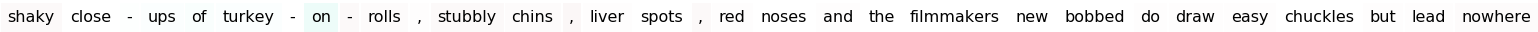

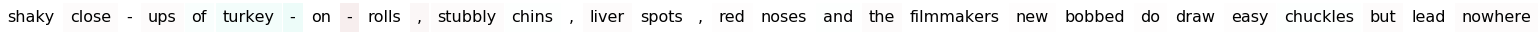

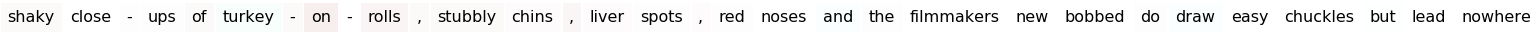

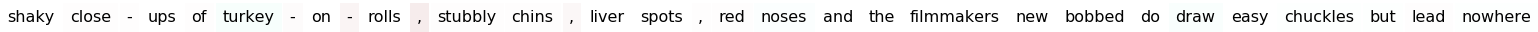

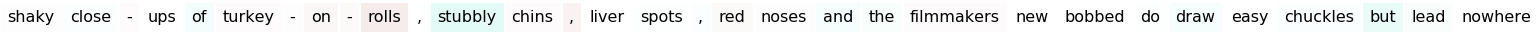

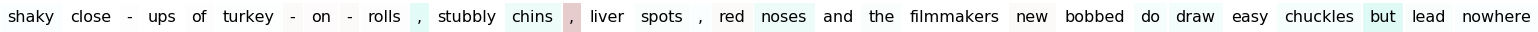

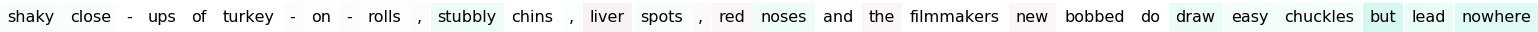

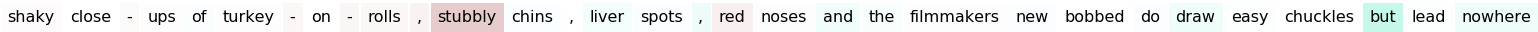

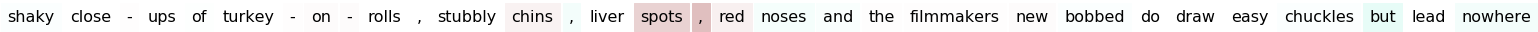

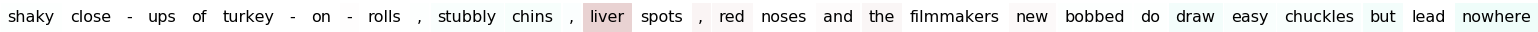

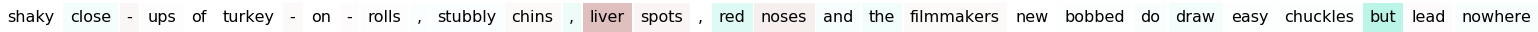

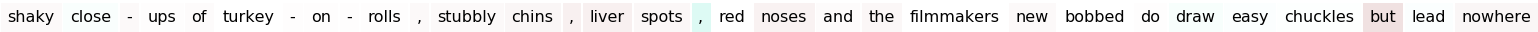

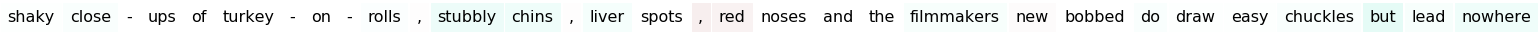

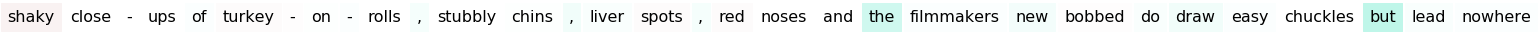

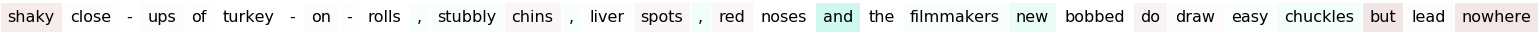

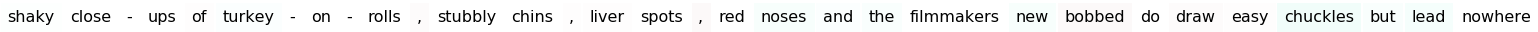

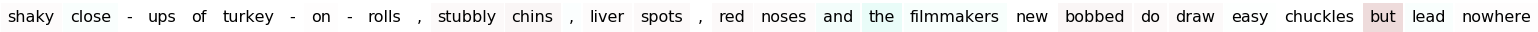

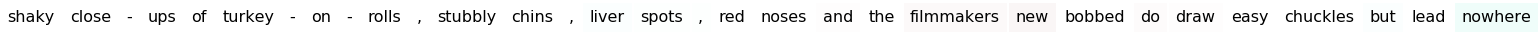

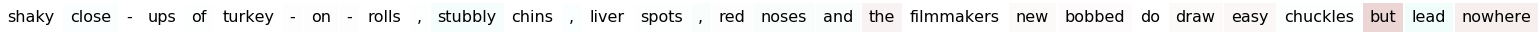

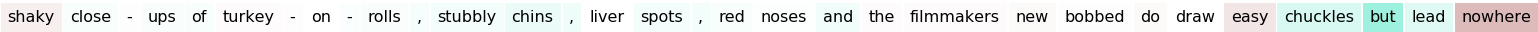

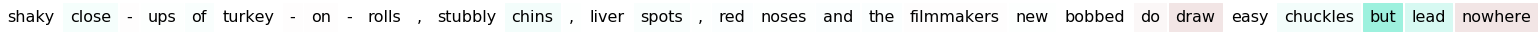

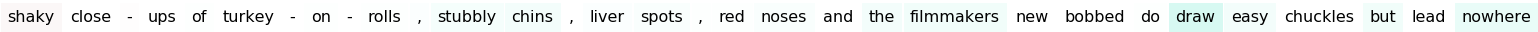

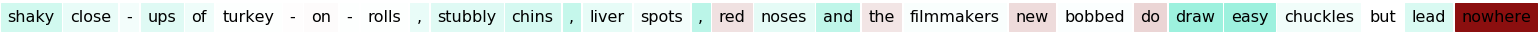

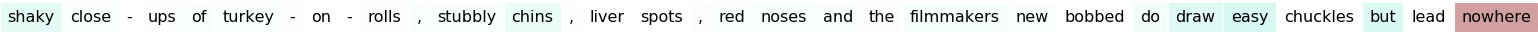

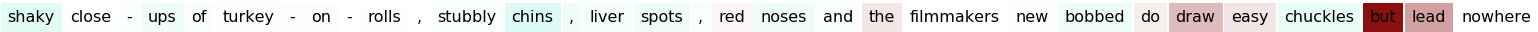

In [ ]:
plot_all(22)

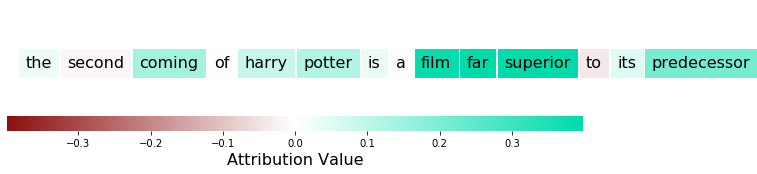

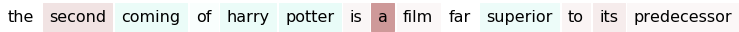

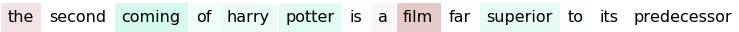

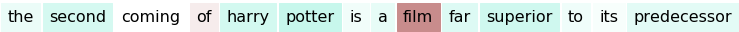

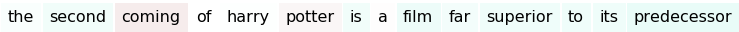

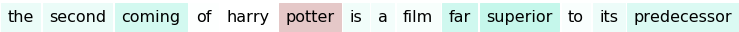

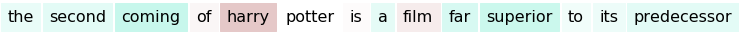

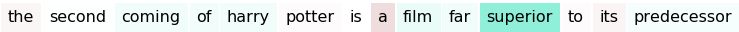

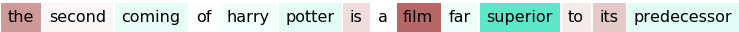

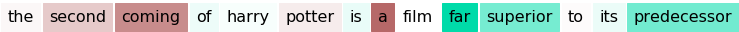

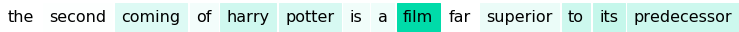

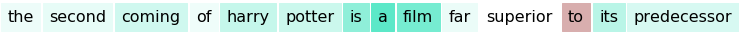

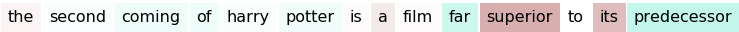

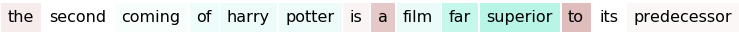

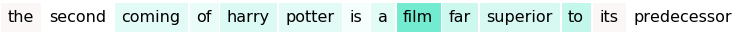

In [ ]:
plot_all(23)

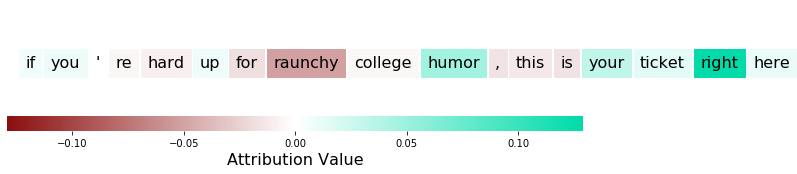

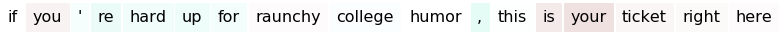

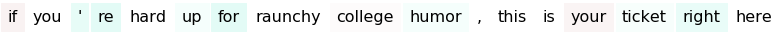

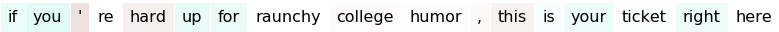

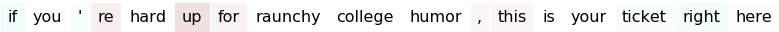

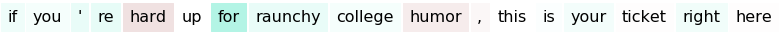

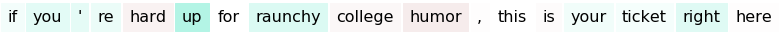

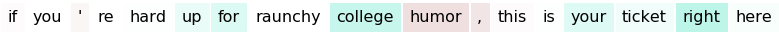

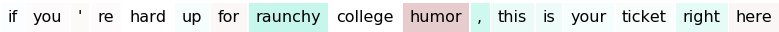

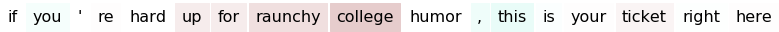

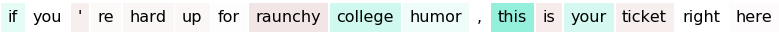

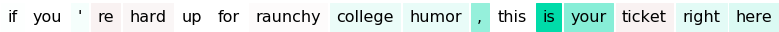

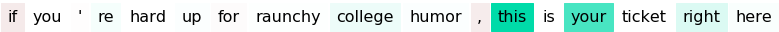

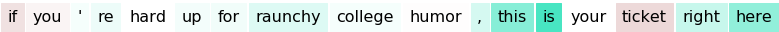

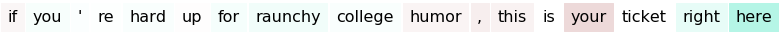

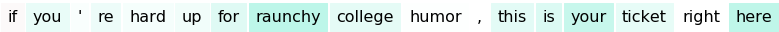

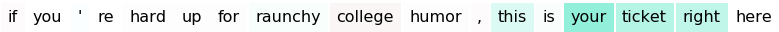

In [ ]:
plot_all(24)

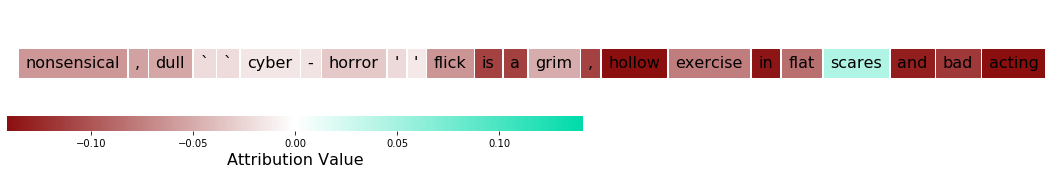

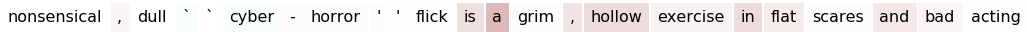

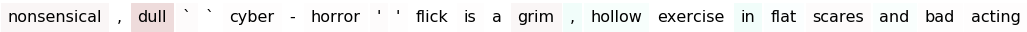

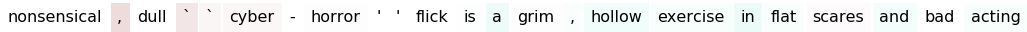

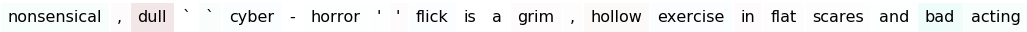

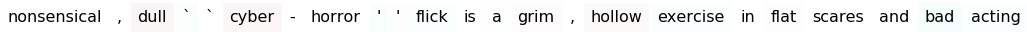

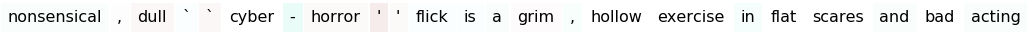

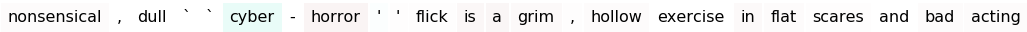

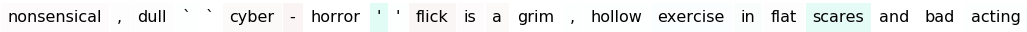

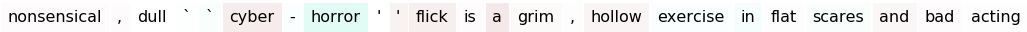

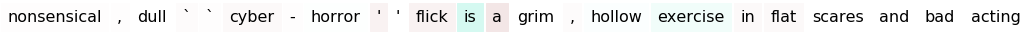

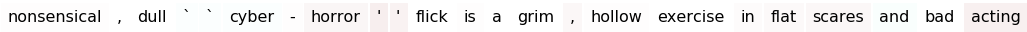

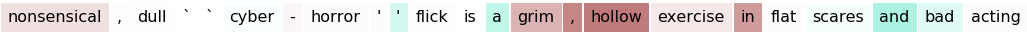

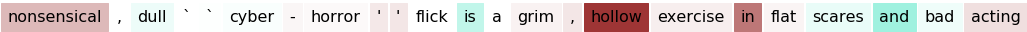

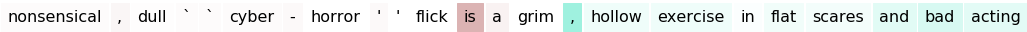

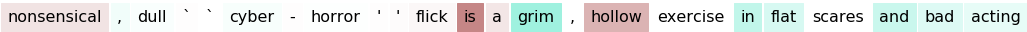

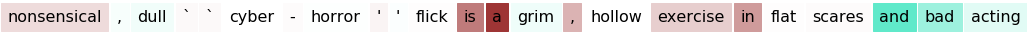

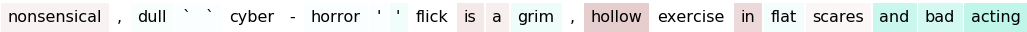

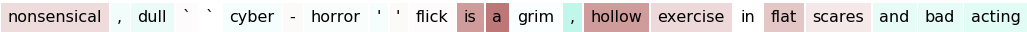

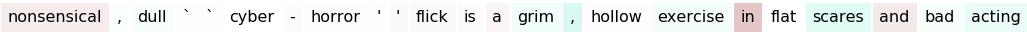

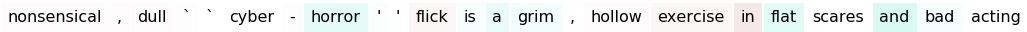

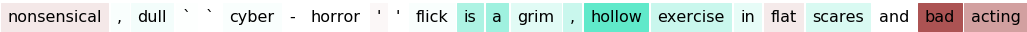

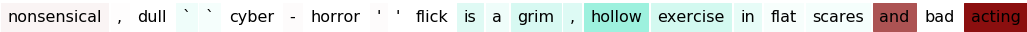

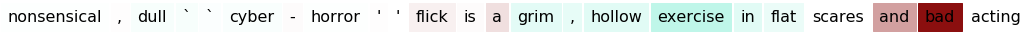

In [ ]:
plot_all(25)

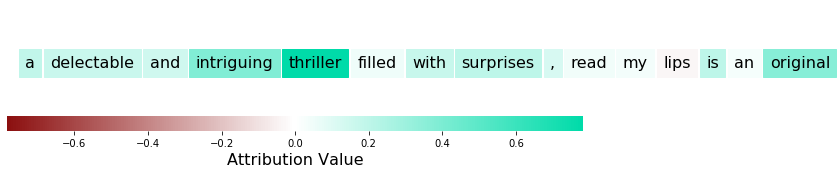

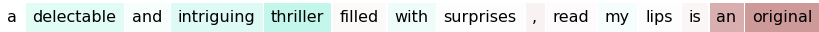

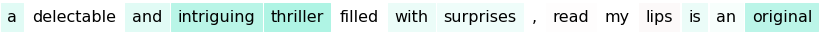

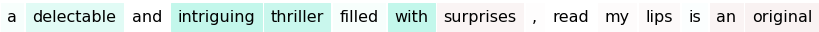

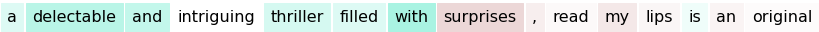

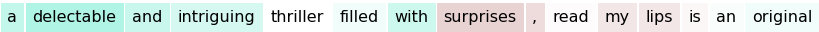

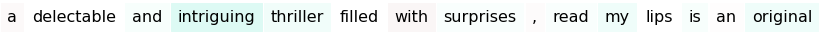

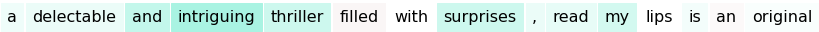

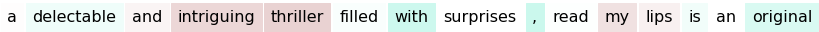

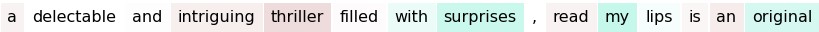

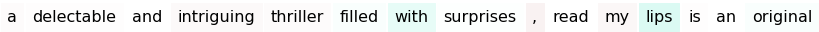

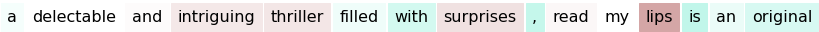

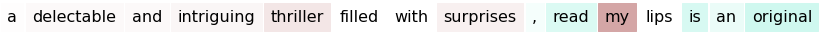

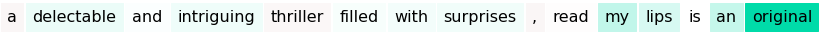

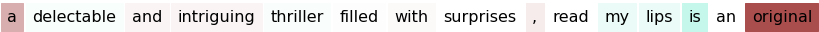

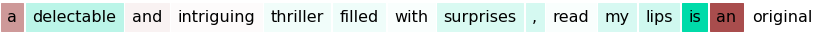

In [ ]:
plot_all(26)

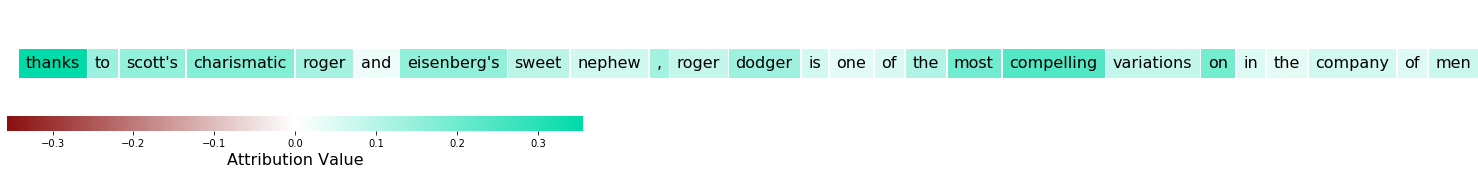

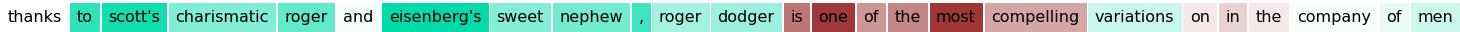

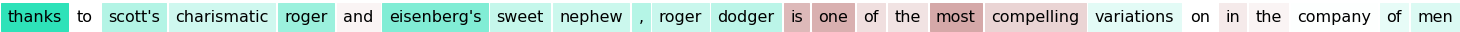

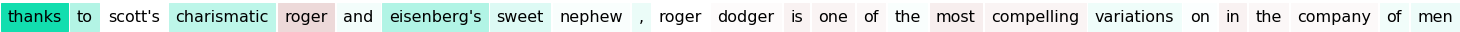

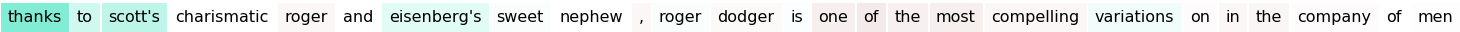

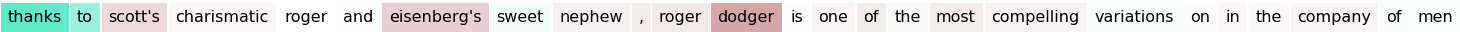

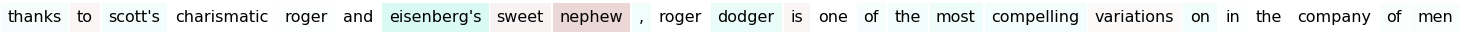

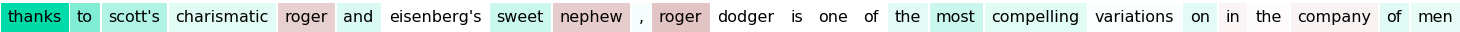

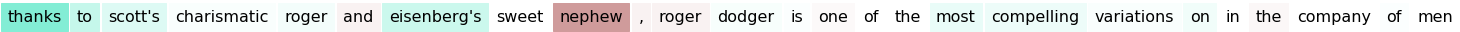

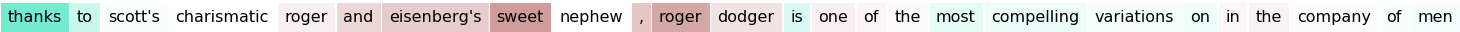

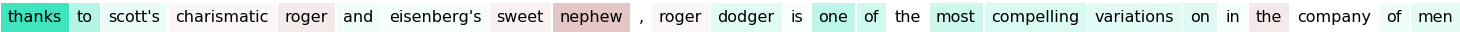

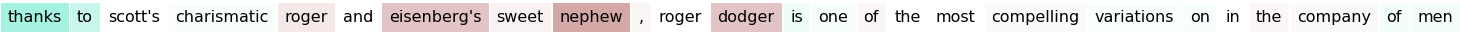

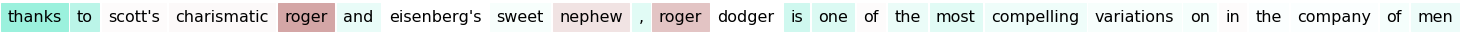

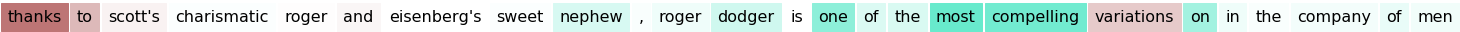

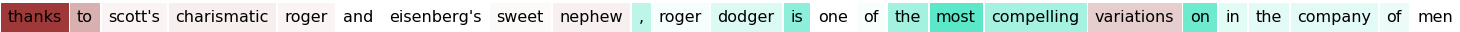

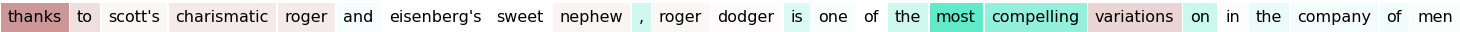

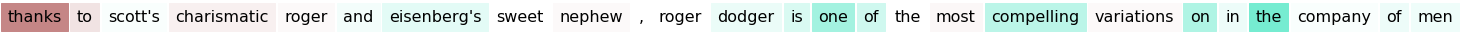

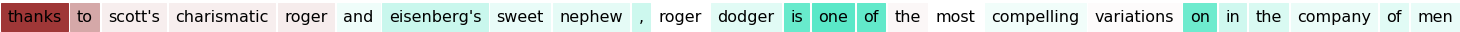

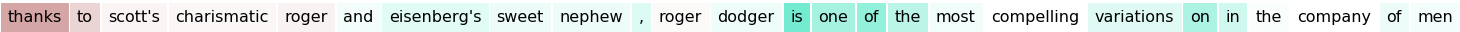

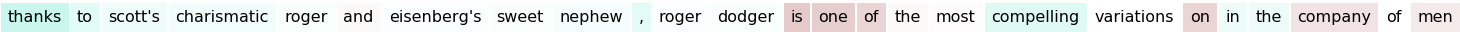

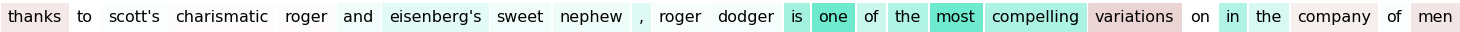

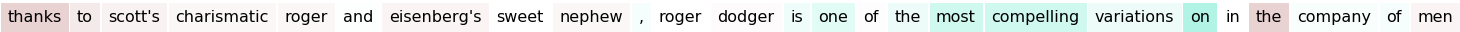

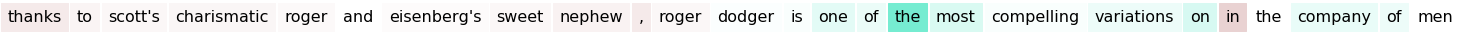

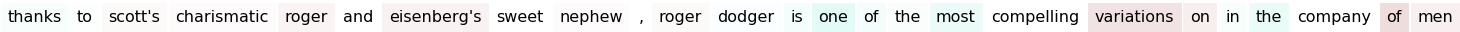

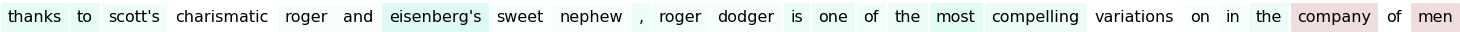

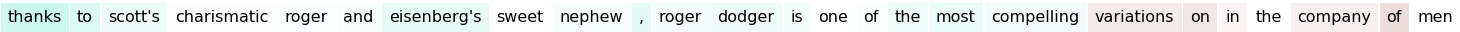

In [ ]:
plot_all(27)

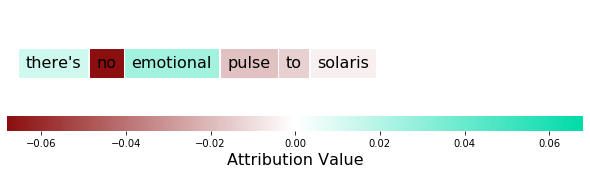

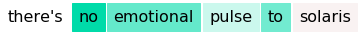

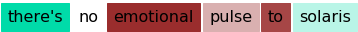

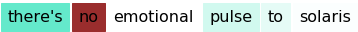

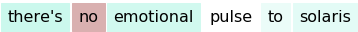

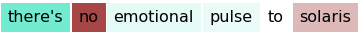

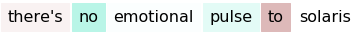

In [ ]:
plot_all(28)

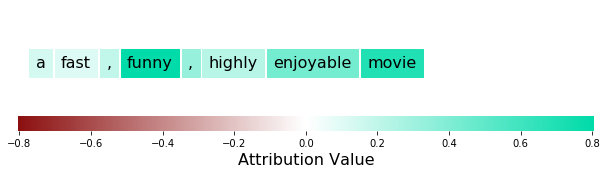

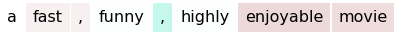

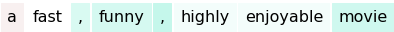

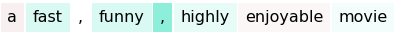

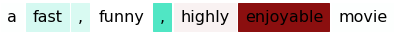

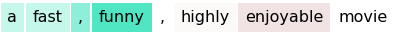

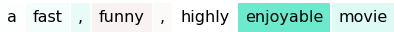

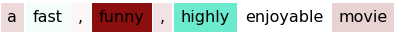

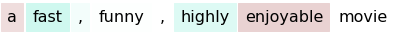

In [ ]:
plot_all(29)

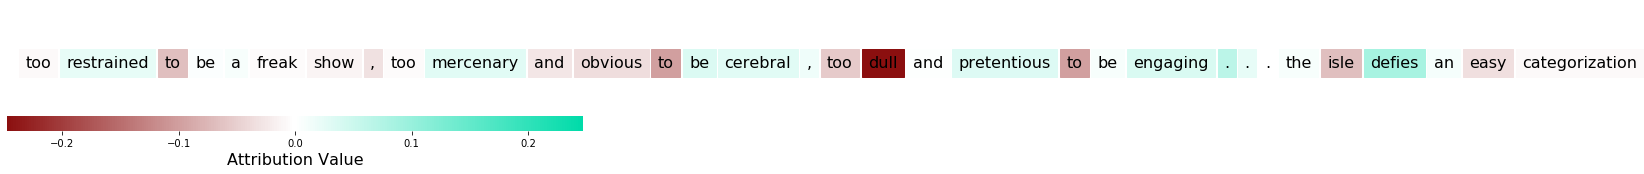

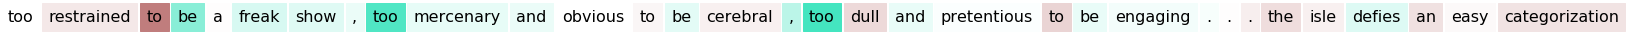

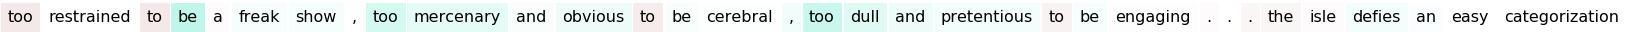

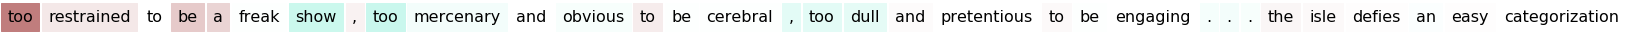

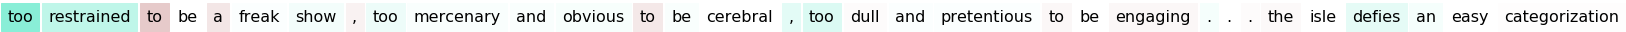

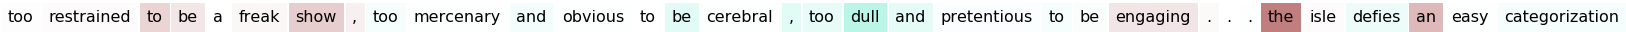

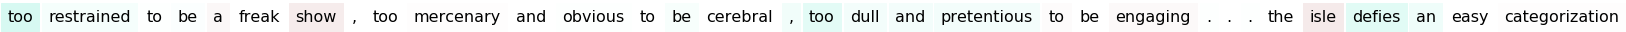

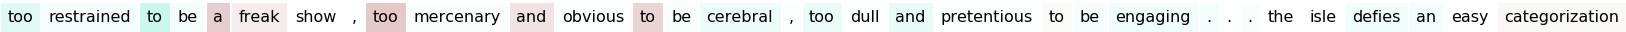

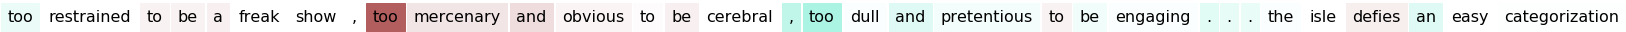

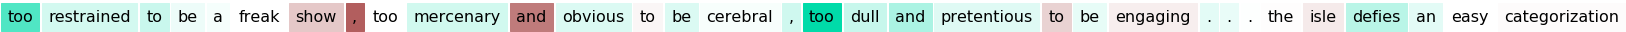

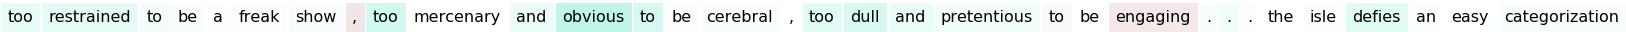

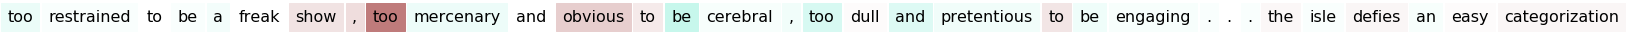

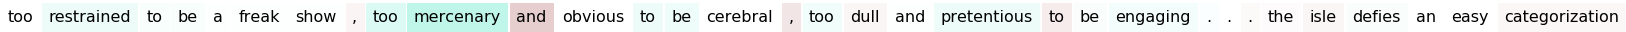

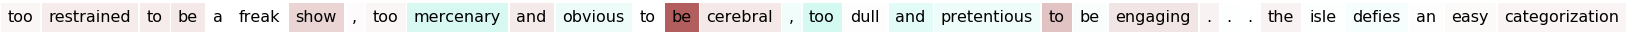

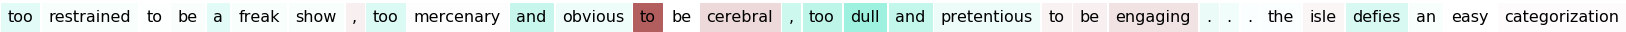

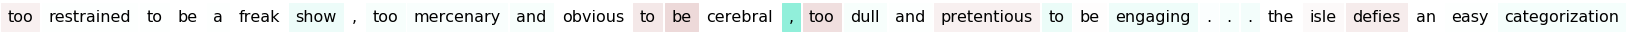

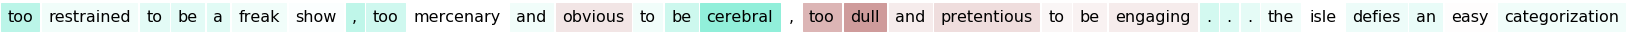

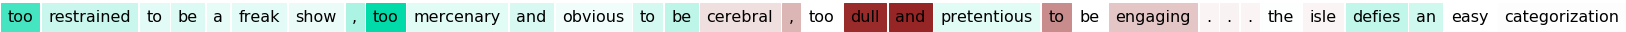

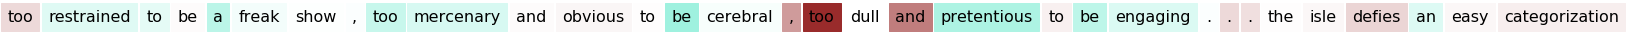

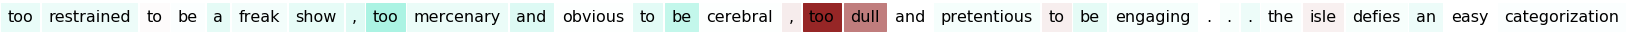

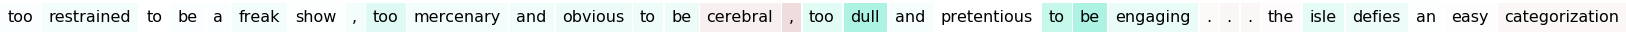

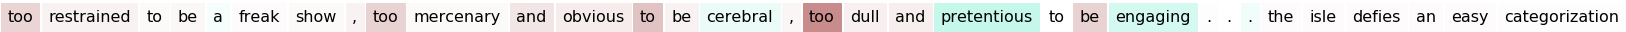

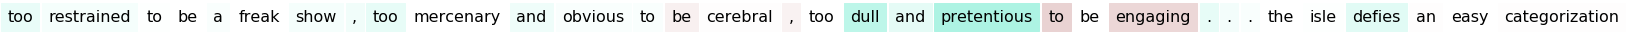

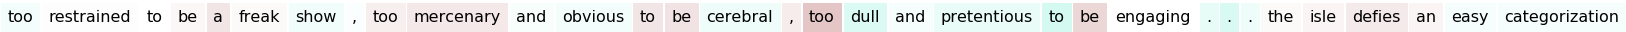

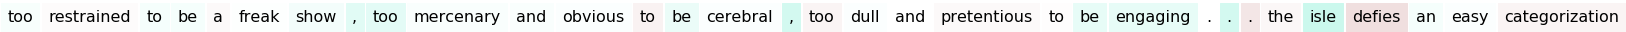

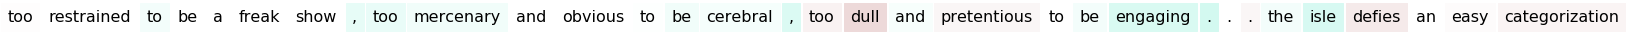

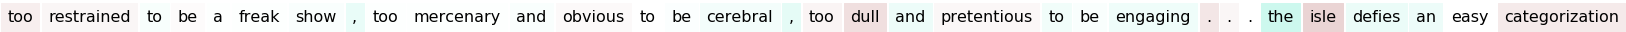

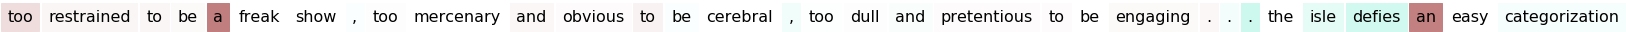

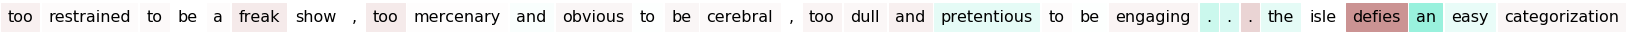

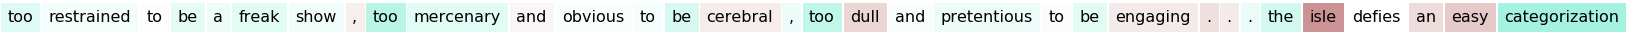

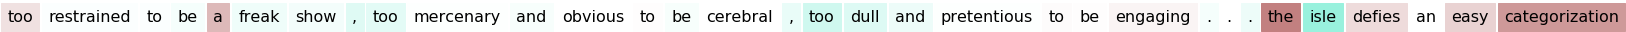

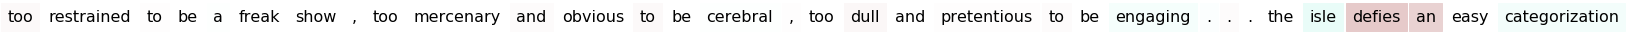

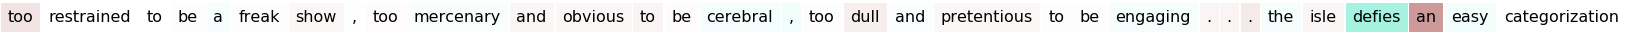

In [ ]:
plot_all(30)

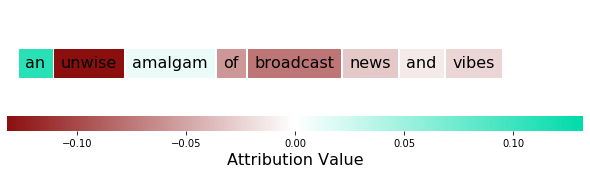

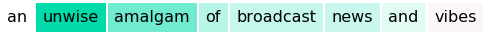

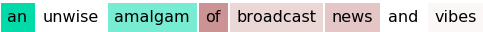

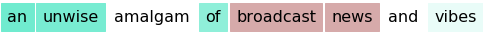

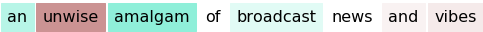

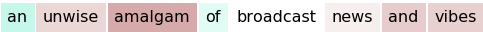

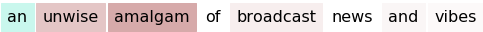

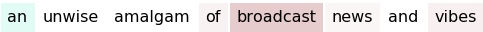

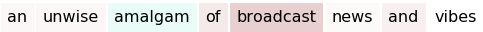

In [ ]:
plot_all(31)